# Simple Neural Network: Coffee Roast Classifier


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('./deeplearning.mplstyle')

import tensorflow as tf
# from tensorflow.keras.layers import Dense # type: ignore
# from keras.layers import Dense

from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2025-12-16 21:08:12.222841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 21:08:12.297352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 21:08:14.580968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. Load the dataset and visualize it

In [2]:
X,Y = load_coffee_data();

print(f"Type X, Y: {type(X), type(Y)}")
print(X.shape, Y.shape)

Type X, Y: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
(200, 2) (200, 1)


In [3]:
print(X[:5])
print(Y[:5])

[[185.32  12.69]
 [259.92  11.87]
 [231.01  14.41]
 [175.37  11.72]
 [187.12  14.13]]
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]]


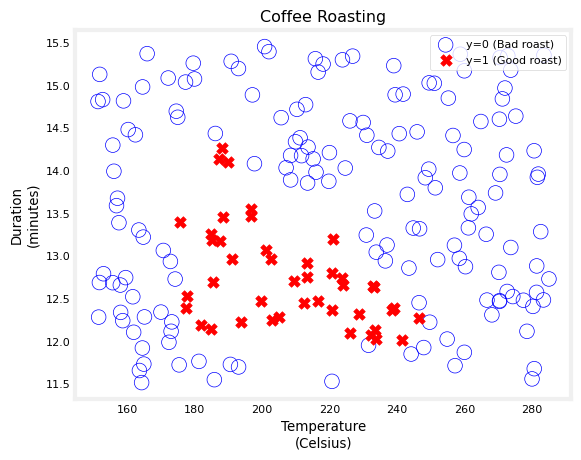

In [4]:
# 2D scatter plot of the data 
# marker 'o' denote points which y = 0
# marker 'x' denote points which y = 1

""" Syntax:
- marker='o' | 'x' | 'X'            : marked symbol
- facecolors='none' | 'green' | ... : inside color of circle symbol
- edgecolors='none' | 'blue' | ...  : edge color of circle symbol
- s=111 | 22 | ...                  : size of symbol
- c='red' | ...                     : color of symbol
"""
plt.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], marker='o', label='y=0 (Bad roast)', facecolors='none', edgecolors='blue', s=111)
plt.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], marker='X', label='y=1 (Good roast)', c='red', s=69)

plt.legend(loc='upper right')
plt.xlabel("Temperature\n(Celsius)")
plt.ylabel("Duration\n(minutes)")
plt.title("Coffee Roasting")

plt.show();

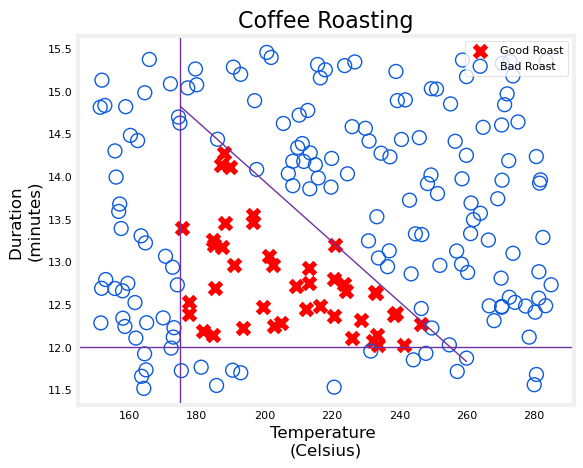

In [5]:
plt_roast(X, Y)

# 2. Normalize the data

Normalize data &rarr; quickly fitting the weights of the neural network.

In [ ]:
print(f"(-) Temperature(Celsius) pre normalization: Max, Min: {np.max(X[:, 0]):.2f}, {np.min(X[:, 0]):.2f}")
print(f"(-) Duration(minutes) pre normalization: Max, Min: {np.max(X[:, 1]):.2f}, {np.min(X[:, 1]):.2f}")


# Create a "Normalization layer"
norm_layer = tf.keras.layers.Normalization(axis=-1) # by column
# Learn mean & variances
norm_layer.adapt(X) #  (like module.fit())
# Normalize
X_norm = norm_layer(X)


print(f"(+) Temperature(Celsius) post normalization: Max, Min: {np.max(X_norm[:, 0]):.2f}, {np.min(X_norm[:, 0]):.2f}")
print(f"(+) Duration(minutes) post normalization: Max, Min: {np.max(X_norm[:, 1]):.2f},  {np.min(X_norm[:, 1]):.2f}")
    

(-) Temperature(Celsius) pre normalization: Max, Min: 284.99, 151.32
(-) Duration(minutes) pre normalization: Max, Min: 15.45, 11.51
(+) Temperature(Celsius) post normalization: Max, Min: 1.66, -1.69
(+) Duration(minutes) post normalization: Max, Min: 1.79,  -1.70


Tile/replicate data &rarr; increase dataset size for better training.
But it consumes more memory and we just want to demonstrate the neural network.

Instead of using 200 samples and train the model with 1000 epochs,

```model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=1)```

We tile the data to have 200,000 samples and train with 10 epochs.

In [22]:
X_tile = np.tile(X_norm, (1000, 1)) # tile/replicate 1000 times by axis=0 (rows) and 1 time by column
Y_tile = np.tile(Y, (1000, 1))

print(X_tile.shape, Y_tile.shape)

(200000, 2) (200000, 1)


# 3. TensorFlow Neural Network Model

## Model

<center>
<img src="./images/C2_W1_RoastingNetwork.PNG" alt="Neural Network Architecture"/>
<br>
Figure: Neural Network Architecture
</center>

There are 2 layers with sigmoid activation function.

In [25]:
tf.random.set_seed(1111) # For reproducibility (archive same results each run)
# Design model:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(units=3, activation='sigmoid', name='layer1'),
        tf.keras.layers.Dense(units=1, activation='sigmoid', name='layer2')
    ]
)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)